In [2]:
% load_ext rpy2.ipython

In [7]:
%%R
#ip <- installed.packages() 
#pkgs.to.remove <- ip[!(ip[,"Priority"] %in% c("base", "recommended")), 1]
#sapply(pkgs.to.remove, remove.packages)

Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
Removing package from ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspe

In [10]:
%%R
#source("http://bioconductor.org/biocLite.R")

Installing package into ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
trying URL 'http://www.bioconductor.org/packages/3.0/bioc/src/contrib/BiocInstaller_1.16.5.tar.gz'
Content type 'application/x-gzip' length 14136 bytes (13 Kb)
opened URL
downloaded 13 Kb


The downloaded source packages are in
	‘/private/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T/Rtmp027es9/downloaded_packages’
Bioconductor version 3.0 (BiocInstaller 1.16.5), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install


In [11]:
%%R
#biocLite("phyloseq")

BioC_mirror: http://bioconductor.org
Using Bioconductor version 3.0 (BiocInstaller 1.16.5), R version 3.1.2.
Installing package(s) 'phyloseq'
also installing the dependencies ‘base64enc’, ‘brew’, ‘checkmate’, ‘DBI’, ‘fail’, ‘RSQLite’, ‘sendmailR’, ‘XML’, ‘xtable’, ‘GenomeInfoDb’, ‘BatchJobs’, ‘BBmisc’, ‘AnnotationDbi’, ‘annotate’, ‘Formula’, ‘latticeExtra’, ‘acepack’, ‘gridExtra’, ‘pkgmaker’, ‘registry’, ‘rngtools’, ‘gridBase’, ‘colorspace’, ‘doParallel’, ‘stringi’, ‘RJSONIO’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘XVector’, ‘zlibbioc’, ‘chron’, ‘GenomicRanges’, ‘Rcpp’, ‘RcppArmadillo’, ‘Biobase’, ‘BiocParallel’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘Hmisc’, ‘iterators’, ‘digest’, ‘gtable’, ‘proto’, ‘magrittr’, ‘NMF’, ‘irlba’, ‘stringr’, ‘RColorBrewer’, ‘dichromat’, ‘munsell’, ‘labeling’, ‘permute’, ‘ade4’, ‘ape’, ‘biom’, ‘Biostrings’, ‘data.table’, ‘DESeq2’, ‘foreach’, ‘ggplot2’, ‘igraph’, ‘multtest’, ‘plyr’, ‘reshape2’, ‘scales’, ‘vegan’

trying URL 'http://cran.fhcrc.org/src/con

In [16]:
%%R
#source("http://bioconductor.org/biocLite.R")
#biocLite("phyloseq")

Bioconductor version 3.0 (BiocInstaller 1.16.5), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: http://bioconductor.org
Using Bioconductor version 3.0 (BiocInstaller 1.16.5), R version 3.1.2.
Installing package(s) 'phyloseq'
trying URL 'http://bioconductor.org/packages/3.0/bioc/src/contrib/phyloseq_1.10.0.tar.gz'
Content type 'application/x-gzip' length 2723228 bytes (2.6 Mb)
opened URL
downloaded 2.6 Mb


The downloaded source packages are in
	‘/private/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T/Rtmp027es9/downloaded_packages’


In [3]:
%%R
library("phyloseq")

In [4]:
%%R
library(ggplot2)

Need help? Try the ggplot2 mailing list: http://groups.google.com/group/ggplot2.


In [5]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", treefilename= ../../SeqData/f parseFunction = parse_taxonomy_greengenes)

In [6]:
%%R
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4858 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 4858 taxa by 7 taxonomic ranks ]


In [1]:
%%R
physeq.noK <- subset_samples(physeq,Trtmt!="K")
physeq.noK

ERROR: Cell magic `%%R` not found.


In [11]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>10000)
physeq.noSmall

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4858 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 4858 taxa by 7 taxonomic ranks ]


In [79]:
%%R
physeq.noSmall.FQ <- subset_samples(physeq,sample_sums(physeq)>1000)
physeq.noSmall.FQ <- subset_samples(physeq.noSmall.FQ,Trtmt==c("Q","F"))
physeq.noSmall.FQ

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4858 taxa and 27 samples ]
sample_data() Sample Data:       [ 27 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 4858 taxa by 7 taxonomic ranks ]


In [12]:
%%R
ps<-physeq.noSmall

In [13]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [14]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.NMDS.full = ordinate(ps_snorm, method = "NMDS", distance = "bray")
NMDS.full = plot_ordination(ps_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)
NMDS.full$Samples = rownames(NMDS.full)

Run 0 stress 0.1532008 
Run 1 stress 0.2046906 
Run 2 stress 0.1837486 
Run 3 stress 0.1826498 
Run 4 stress 0.1950373 
Run 5 stress 0.1938065 
Run 6 stress 0.1736244 
Run 7 stress 0.1894716 
Run 8 stress 0.1886917 
Run 9 stress 0.2004408 
Run 10 stress 0.1482078 
... New best solution
... procrustes: rmse 0.0504125  max resid 0.3398143 
Run 11 stress 0.1851969 
Run 12 stress 0.1946793 
Run 13 stress 0.2023544 
Run 14 stress 0.1596451 
Run 15 stress 0.1721943 
Run 16 stress 0.1572102 
Run 17 stress 0.149818 
Run 18 stress 0.172969 
Run 19 stress 0.1607905 
Run 20 stress 0.1481976 
... New best solution
... procrustes: rmse 0.004541205  max resid 0.02758374 


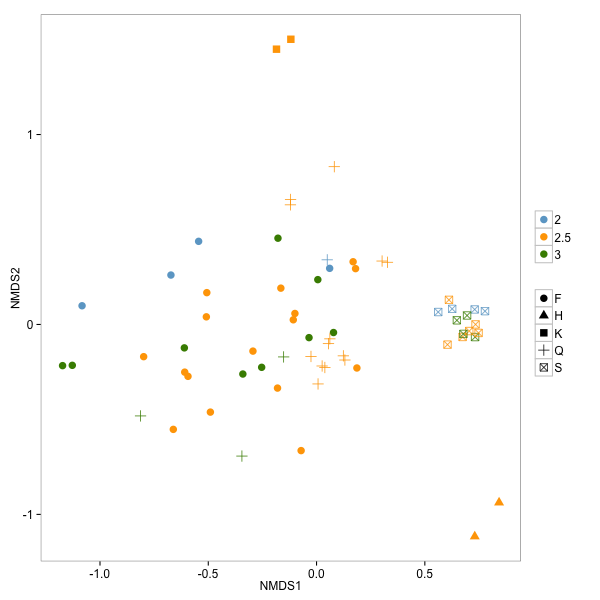

In [19]:
%%R -h 600 -w 600
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

#D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
#D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
#D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = Month, shape = Trtmt))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","orange","chartreuse4","gold1","red3","black"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
#p = p + facet_wrap(~Trtmt, scales="free")
# The axis scales could be all optimized individually
#p = p + facet_grid(~Trtmt)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
#plot.full.byDay = p
p